<a href="https://colab.research.google.com/github/TahminaAnondi/2DArray/blob/main/Another_copy_of_AirPollution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import Libraries
import tensorflow as tf
import numpy as np #Linear Algebra
import matplotlib.pyplot as plt #Data visualization
import pandas as pd #data manipulation

import warnings
warnings.filterwarnings('ignore') #Ignore warnings

#Make sure Tensorflow is version 2.0 or higher
print('Tensorflow Version:', tf.__version__)

Tensorflow Version: 2.15.0


In [ ]:
import pandas as pd

# Assuming 'pollution' DataFrame is filtered for desired time period and city
# Replace these lines with your actual code to load and filter the data
pollution = pd.read_csv("/content/AirPollution.xlsx - Sheet5.csv")
pollution['Date'] = pd.to_datetime(pollution[['Year', 'Month', 'Day']])
pollution.set_index('Date', inplace=True)
pollution = pollution[(pollution.City == 'PORT ALLEN') &
                      (pollution.index >= '2011-01-01') &
                      (pollution.index <= '2018-12-31')]
pollution = pollution.drop(['City', 'Year', 'Month', 'Day'], axis=1)

# Create a dictionary with dates and pm25 values
pm25_dict = {'Date': pd.date_range(start="2011-01-01", end="2018-12-31", freq="D"),
             'pm25': pollution['pm25'].tolist()}  # Assuming 'pm25' is the column with pm25 values

print(pm25_dict)


{'Date': DatetimeIndex(['2011-01-01', '2011-01-02', '2011-01-03', '2011-01-04',
               '2011-01-05', '2011-01-06', '2011-01-07', '2011-01-08',
               '2011-01-09', '2011-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=2922, freq='D'), 'pm25': [35.0, 32.0, 75.0, 169.0, 83.0, 77.0, 61.0, 58.0, 76.0, 96.0, 95.0, 87.0, 102.0, 131.0, 136.0, 137.0, 113.0, 112.0, 86.0, 94.0, 67.0, 98.0, 177.0, 80.0, 64.0, 90.0, 89.0, 101.0, 104.0, 226.0, 95.0, 88.0, 84.0, 62.0, 46.0, 71.0, 84.0, 50.0, 50.0, 51.0, 82.0, 69.0, 85.0, 78.0, 91.0, 131.0, 138.0, 129.0, 133.0, 143.0, 80.0, 91.0, 153.0, 146.0, 127.0, 130.0, 101.0, 71.0, 113.0, 132.0, 166.0, 99.0, 74.0, 54.0, 87.0, 125.0, 79.0, 81.0, 91.0, 99.0, 96.0, 60.0, 99.0, 75.0, 114.0, 140.0, 84.0, 79.0, 77.0, 129.0, 50.0, 132.0, 96.0, 119

In [ ]:
#Impute the missing value
# Checks for and imputes missing dates
a = pd.date_range(start="2011-01-01", end="2018-12-31", freq="D")  # Continuous dates
b = pollution.index  # Our time series
diff_dates = a.difference(b)  # Finds what in 'a' is not in 'b'

td = pd.Timedelta(1, "d")  # 1 day
for date in diff_dates:
    prev_date = date - td
    if prev_date in pollution.index:
        prev_val = pollution.loc[prev_date, 'pm25']  # Takes the previous pm25 value if it exists
        pollution.loc[date, 'pm25'] = prev_val  # Imputes previous pm25 value for the missing date

pollution.sort_index(inplace=True)
pollution.index.freq = "D"  # Sets the time index frequency as daily

print(pollution.head())


             pm25
Date             
2011-01-01   35.0
2011-01-02   32.0
2011-01-03   75.0
2011-01-04  169.0
2011-01-05   83.0


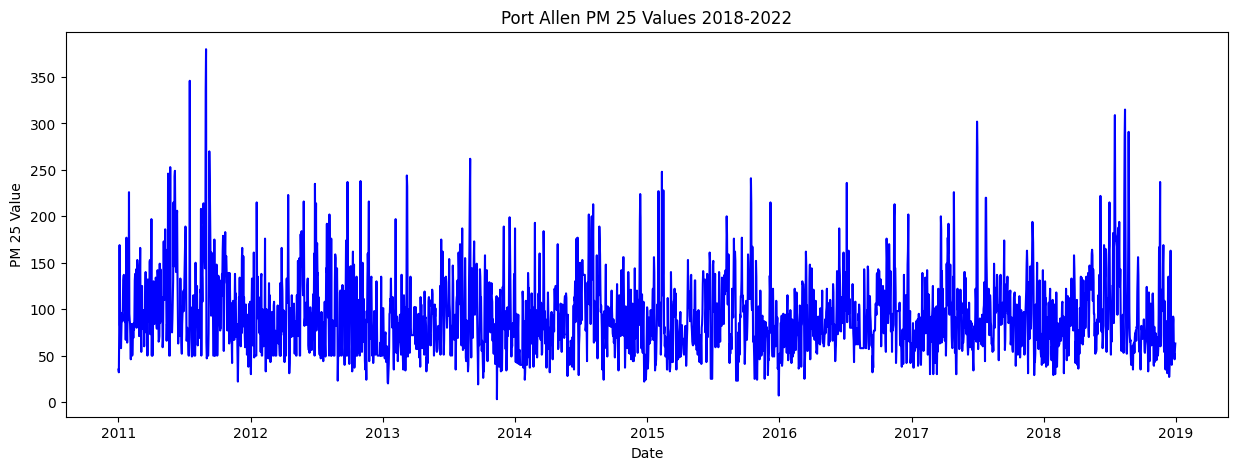

In [ ]:
#displays a plot of the pm25 values since 2018
fig = plt.figure(figsize=(15,5))
plt.plot(pollution, color='blue')
plt.xlabel('Date')
plt.ylabel('PM 25 Value')
plt.title('Port Allen PM 25 Values 2018-2022')
plt.show()

In [ ]:
#Split the time series data into a train and test set
end_train_ix = pd.to_datetime('2016-12-31')
train = pollution[:end_train_ix] # Jan 2011-2016
test = pollution[end_train_ix:] # Jan 2017-2018

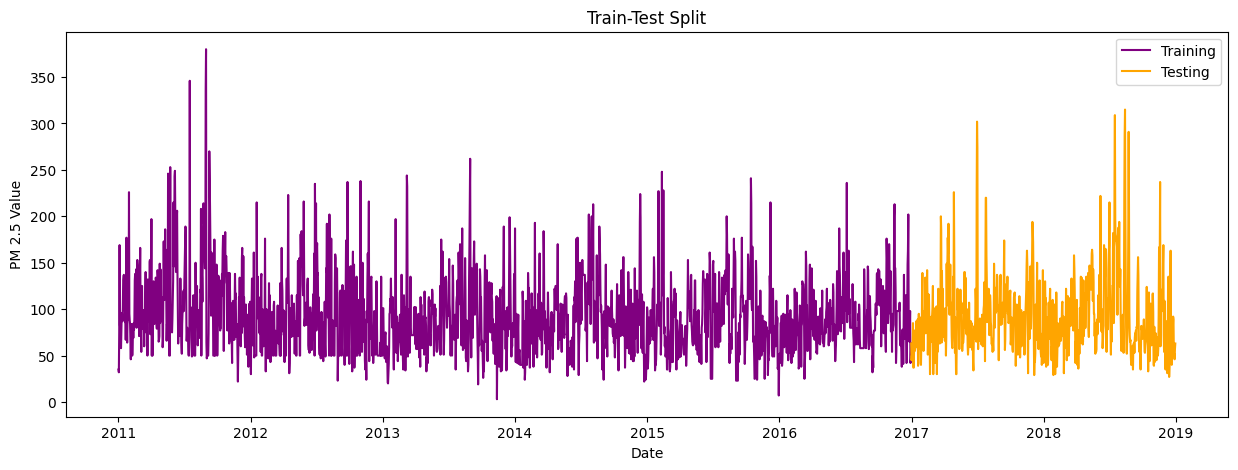

In [ ]:
#displays a plot of the train/test split
fig = plt.figure(figsize=(15,5))
plt.plot(train, color='purple', label='Training')
plt.plot(test, color='orange', label='Testing')
plt.xlabel('Date')
plt.ylabel('PM 2.5 Value')
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [ ]:
#Creates a windowed dataset from the time series data
WINDOW = 14 #the window value... 14 days

#converts values to TensorSliceDataset
train_data = tf.data.Dataset.from_tensor_slices(train.values)

#takes window size + 1 slices of the dataset
train_data = train_data.window(WINDOW+1, shift=1, drop_remainder=True)

#flattens windowed data by batching
train_data = train_data.flat_map(lambda x: x.batch(WINDOW+1))

#creates features and target tuple
train_data = train_data.map(lambda x: (x[:-1], x[-1]))

#shuffles dataset
train_data = train_data.shuffle(1_000)

#creates batches of windows
train_data = train_data.batch(32).prefetch(1)

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('mae') < 10.0:
            print("MAE under 10.0... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Lambda, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber


lstm_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

lstm_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 14, 1)             0         
                                                                 
 bidirectional (Bidirection  (None, 14, 256)           133120    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2

In [ ]:
#Trains LSTM Model
lstm_history = lstm_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
69/69 [==============================] - 17s 114ms/step - loss: 35.8990 - mae: 36.3961 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 8s 113ms/step - loss: 30.7574 - mae: 31.2541 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 7s 93ms/step - loss: 30.9899 - mae: 31.4864 - lr: 0.0099
Epoch 4/100
69/69 [==============================] - 7s 103ms/step - loss: 30.7437 - mae: 31.2414 - lr: 0.0098
Epoch 5/100
69/69 [==============================] - 13s 182ms/step - loss: 29.8165 - mae: 30.3135 - lr: 0.0097
Epoch 6/100
69/69 [==============================] - 6s 93ms/step - loss: 28.5040 - mae: 29.0012 - lr: 0.0096
Epoch 7/100
69/69 [==============================] - 7s 98ms/step - loss: 27.5922 - mae: 28.0884 - lr: 0.0095
Epoch 8/100
69/69 [==============================] - 7s 95ms/step - loss: 28.4533 - mae: 28.9483 - lr: 0.0094
Epoch 9/100
69/69 [==============================] - 8s 109ms/step - loss: 28.5463 - mae: 29.0421 - lr: 0.0093
Epo

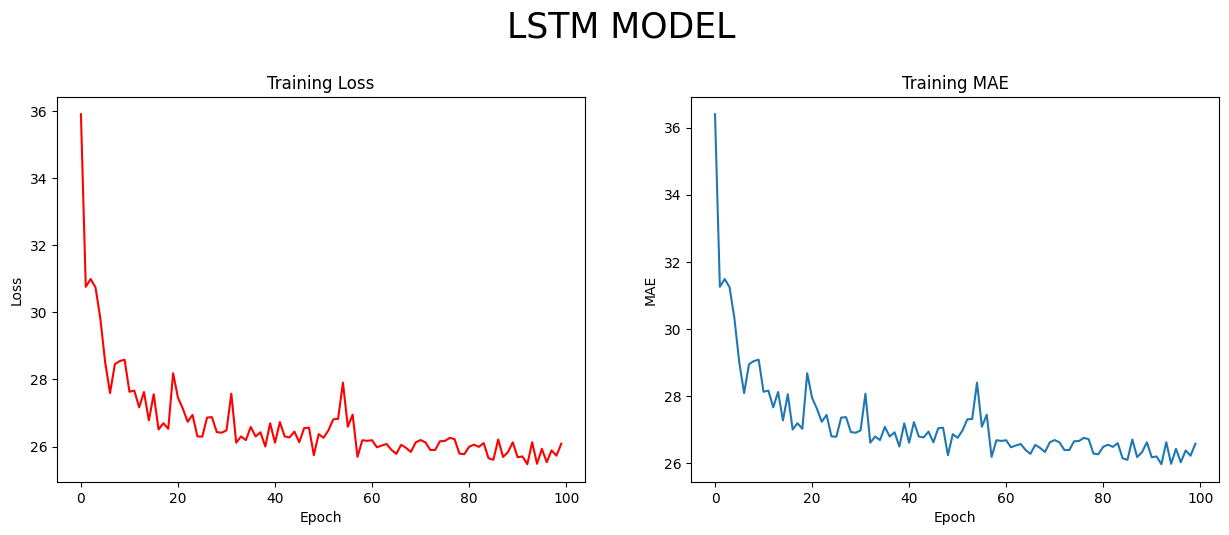

					FINAL LOSS: 26.08 | FINAL MAE: 26.58


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(lstm_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(lstm_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'LSTM MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(lstm_history.history['loss'][-1], 2),
                                                 round(lstm_history.history['mae'][-1] ,2)))

In [ ]:
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D, Flatten


cnn_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=32, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    GlobalAveragePooling1D(),
    Flatten(),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])

cnn_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 14, 32)            128       
                                                                 
 conv1d_1 (Conv1D)           (None, 14, 64)            6208      
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

In [ ]:
#Trains CNN Model
cnn_history = cnn_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
69/69 [==============================] - 2s 7ms/step - loss: 36.9563 - mae: 37.4525 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 1s 6ms/step - loss: 35.7447 - mae: 36.2423 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 1s 6ms/step - loss: 33.7544 - mae: 34.2505 - lr: 0.0099
Epoch 4/100
69/69 [==============================] - 1s 11ms/step - loss: 32.3999 - mae: 32.8968 - lr: 0.0098
Epoch 5/100
69/69 [==============================] - 1s 13ms/step - loss: 33.2600 - mae: 33.7576 - lr: 0.0097
Epoch 6/100
69/69 [==============================] - 1s 8ms/step - loss: 30.3697 - mae: 30.8667 - lr: 0.0096
Epoch 7/100
69/69 [==============================] - 1s 7ms/step - loss: 32.3513 - mae: 32.8477 - lr: 0.0095
Epoch 8/100
69/69 [==============================] - 1s 7ms/step - loss: 30.1614 - mae: 30.6579 - lr: 0.0094
Epoch 9/100
69/69 [==============================] - 1s 6ms/step - loss: 29.9395 - mae: 30.4375 - lr: 0.0093
Epoch 10/100
69/6

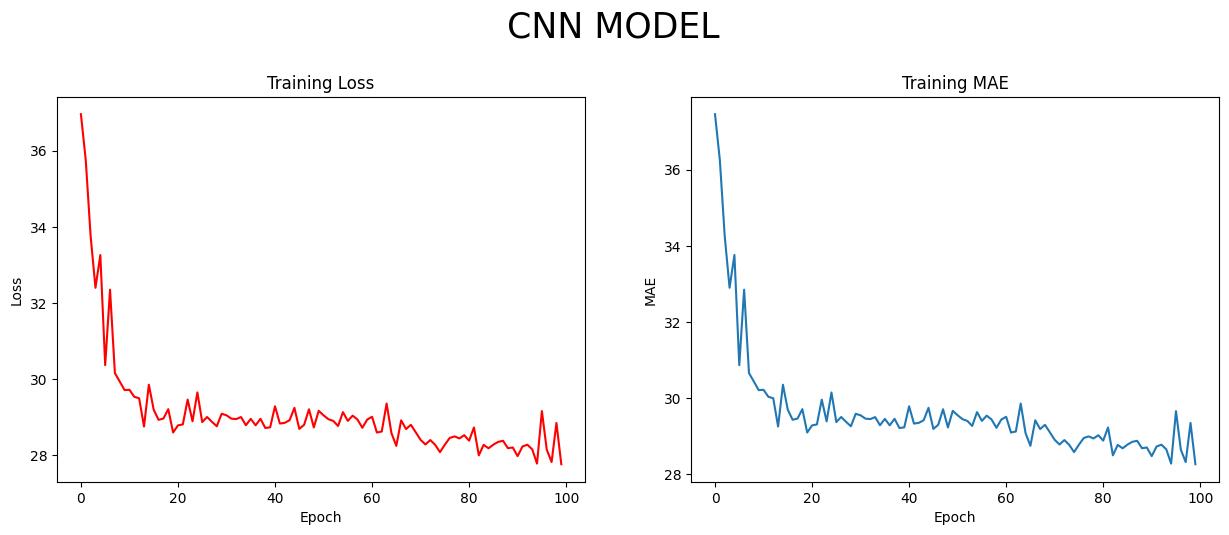

					FINAL LOSS: 27.77 | FINAL MAE: 28.27


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(cnn_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(cnn_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'CNN MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(cnn_history.history['loss'][-1], 2),
                                                 round(cnn_history.history['mae'][-1], 2)))

In [ ]:
mixed_model = Sequential([
    # add extra axis to input data
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW]),
    Conv1D(filters=64, kernel_size=3, strides=1,
           padding='causal', activation='relu'),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(128)),
    Dropout(0.3),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(1)
])


mixed_model.compile(
    loss=Huber(),
    optimizer=Adam(),
    metrics=['mae']
)

mixed_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 14, 1)             0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14, 64)            256       
                                                                 
 bidirectional_2 (Bidirecti  (None, 14, 256)           197632    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 256)               394240    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 512)              

In [ ]:
#Trains Mixed Model
mixed_history = mixed_model.fit(
    train_data,
    epochs=100,
    callbacks=[lr_scheduler, my_callback],
    verbose=1
)

Epoch 1/100
69/69 [==============================] - 17s 107ms/step - loss: 34.4533 - mae: 34.9508 - lr: 0.0100
Epoch 2/100
69/69 [==============================] - 8s 121ms/step - loss: 31.4473 - mae: 31.9441 - lr: 0.0100
Epoch 3/100
69/69 [==============================] - 8s 118ms/step - loss: 31.2085 - mae: 31.7042 - lr: 0.0099
Epoch 4/100
69/69 [==============================] - 7s 103ms/step - loss: 31.0518 - mae: 31.5490 - lr: 0.0098
Epoch 5/100
69/69 [==============================] - 8s 117ms/step - loss: 31.5450 - mae: 32.0415 - lr: 0.0097
Epoch 6/100
69/69 [==============================] - 8s 122ms/step - loss: 31.0645 - mae: 31.5620 - lr: 0.0096
Epoch 7/100
69/69 [==============================] - 8s 109ms/step - loss: 30.8614 - mae: 31.3573 - lr: 0.0095
Epoch 8/100
69/69 [==============================] - 8s 110ms/step - loss: 30.5818 - mae: 31.0773 - lr: 0.0094
Epoch 9/100
69/69 [==============================] - 8s 116ms/step - loss: 31.0974 - mae: 31.5937 - lr: 0.0093


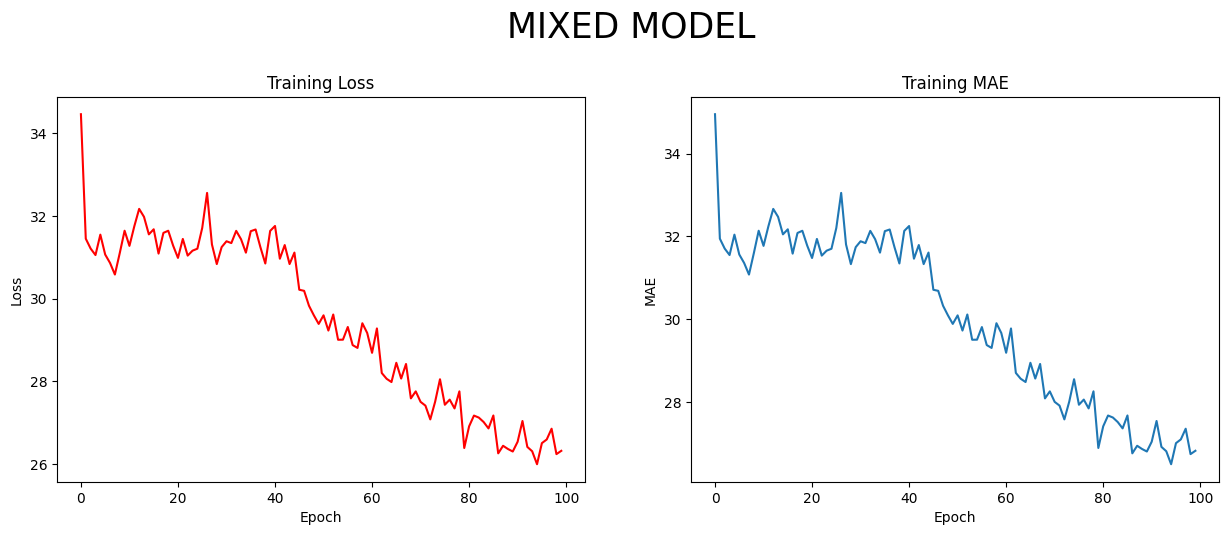

					FINAL LOSS: 26.32 | FINAL MAE: 26.82


In [ ]:
#plots training history
#Plots history of model training
plt.rcParams["figure.figsize"] = (15,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(mixed_history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(mixed_history.history['mae'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('MAE')
axs[1].set_title('Training MAE')

fig.text(0.425,1, 'MIXED MODEL', {'size':25})
plt.show()

print("\t\t\t\t\tFINAL LOSS: {} | FINAL MAE: {}".format(
                                                round(mixed_history.history['loss'][-1], 2),
                                                 round(mixed_history.history['mae'][-1], 2)))

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Assuming train and test are Pandas DataFrames
# Concatenate train[-WINDOW:] and test[:-1] along rows to create forecast_data DataFrame
forecast_data = pd.concat([train[-WINDOW:], test[:-1]])

# Convert forecast_data to a NumPy array
forecast_data_array = forecast_data.values

all_models = [('LSTM MODEL', lstm_model),
              ('CNN MODEL', cnn_model),
              ('MIXED MODEL', mixed_model)]

model_forecasts = {
    'LSTM MODEL': [],
    'CNN MODEL': [],
    'MIXED MODEL': []
}

# Loop through all_models to get forecasts
for name, model in all_models:
    # Convert values to TensorSliceDataset
    test_data = tf.data.Dataset.from_tensor_slices(forecast_data_array)

    # Takes window size slices of the dataset
    test_data = test_data.window(WINDOW, shift=1, drop_remainder=True)

    # Flattens windowed data by batching
    test_data = test_data.flat_map(lambda x: x.batch(WINDOW + 1))

    # Creates batches of windows
    test_data = test_data.batch(32).prefetch(1)

    # Gets model prediction
    preds = model.predict(test_data)

    # Append to forecast dict
    model_forecasts[name].append(preds)


23/23 [==============================] - 3s 35ms/step


In [ ]:
#Gets MAE score of model forecasts

N = test.values.shape[0] #number of samples in test set

lstm_mae = np.abs(test.values - model_forecasts['LSTM MODEL'][0].squeeze()).sum() / N

cnn_mae = np.abs(test.values - model_forecasts['CNN MODEL'][0].squeeze()).sum() / N

mix_mae = np.abs(test.values - model_forecasts['MIXED MODEL'][0].squeeze()).sum() / N


print('MODEL MAE SCORES')
print('=====================================')
print('LSTM MAE:', round(lstm_mae, 2))
print('CNN MAE:', round(cnn_mae, 2))
print('MIXED MAE:', round(mix_mae, 2))

MODEL MAE SCORES
LSTM MAE: 25421.05
CNN MAE: 22685.32
MIXED MAE: 25701.7


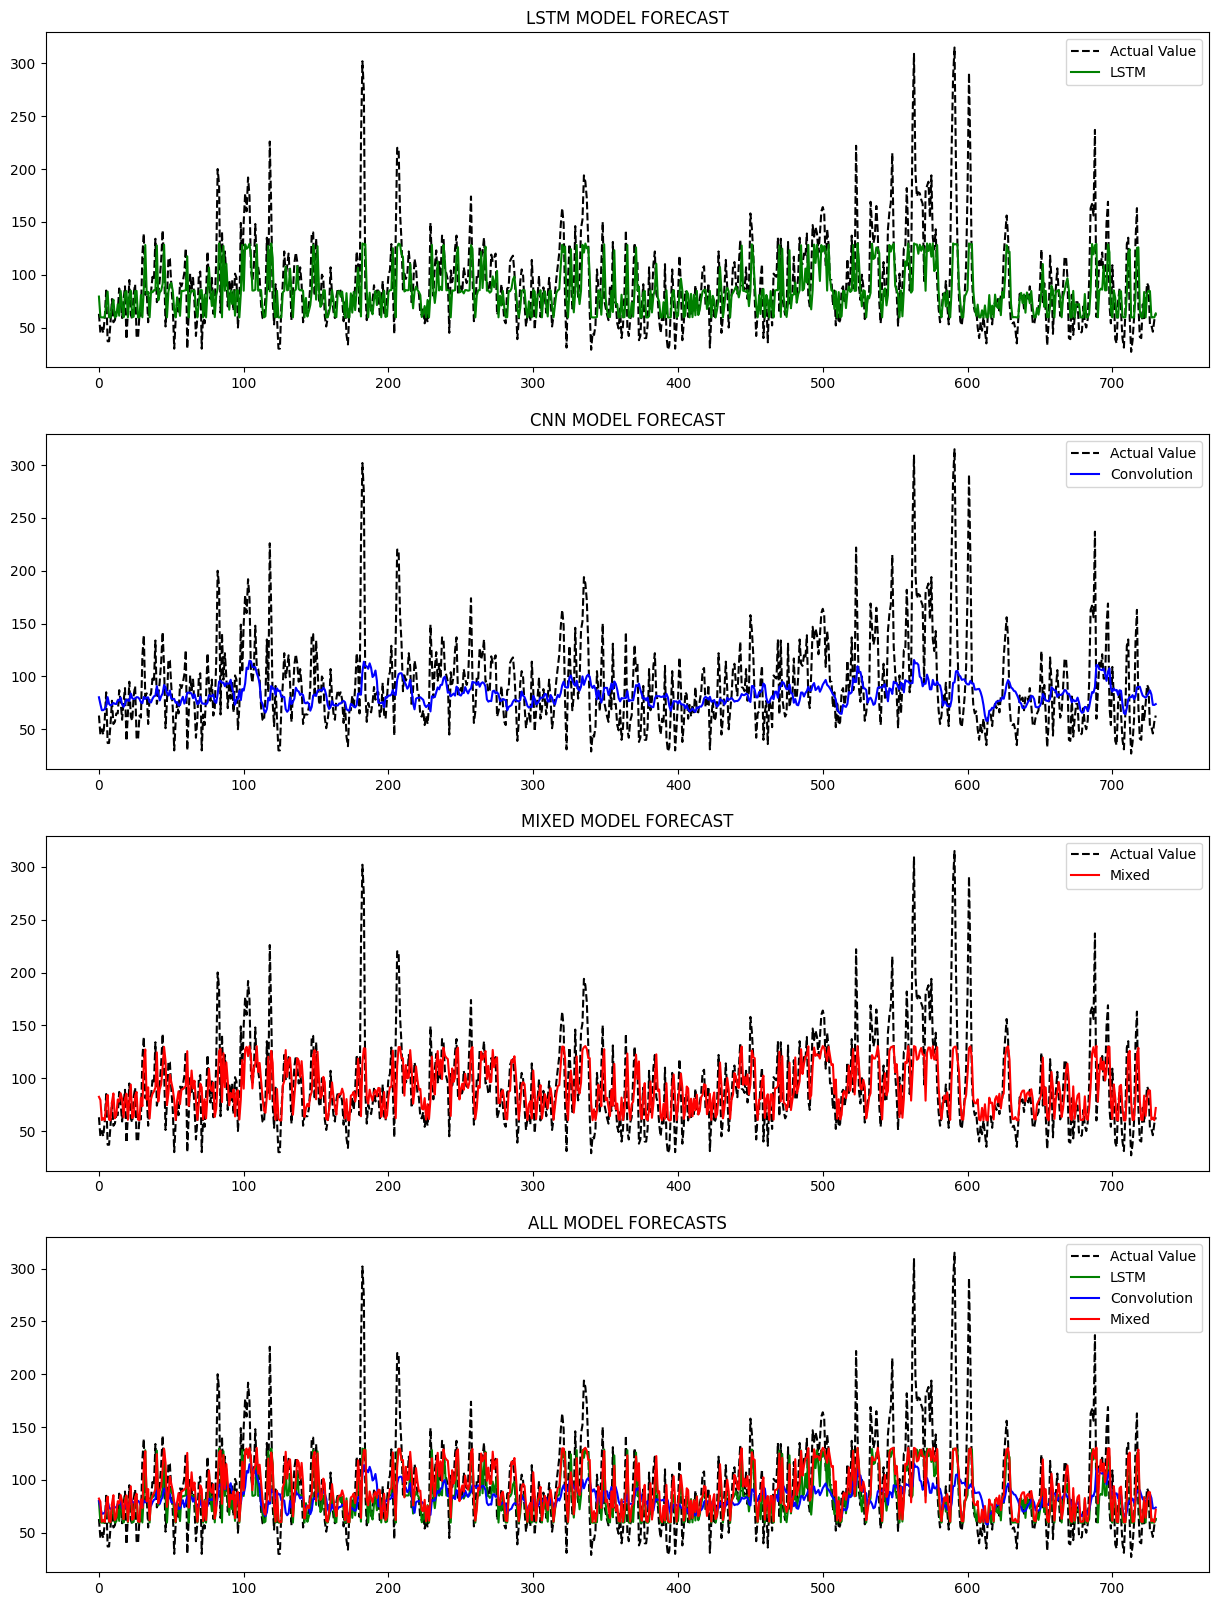

In [ ]:
#displays forecasted data
plt.rcParams["figure.figsize"] = (15,20)
fig, axs = plt.subplots(4, 1)

#LSTM Forecast
axs[0].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[0].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[0].set_title('LSTM MODEL FORECAST')
axs[0].legend()

#CNN Forcast
axs[1].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[1].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[1].set_title('CNN MODEL FORECAST')
axs[1].legend()

#Mixed Model Forecast
axs[2].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[2].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[2].set_title('MIXED MODEL FORECAST')
axs[2].legend()

#All forecasts
axs[3].plot(test.values, color='black', linestyle='--', label='Actual Value')
axs[3].plot(model_forecasts['LSTM MODEL'][0].squeeze(), color='green', label='LSTM')
axs[3].plot(model_forecasts['CNN MODEL'][0].squeeze(), color='blue', label='Convolution')
axs[3].plot(model_forecasts['MIXED MODEL'][0].squeeze(), color='red', label='Mixed')
axs[3].set_title('ALL MODEL FORECASTS')
axs[3].legend()


plt.show()

In [ ]:
import pandas as pd
import geopandas as gpd
!pip install pysal
from pysal.lib import weights
from esda import moran
import numpy as np

# Load the datasets
lung_cancer = pd.read_csv('lung_cancer_data.csv')
pm25 = pd.read_csv('pm25_data.csv')

# Load the shapefile
parishes_shapefile = gpd.read_file('Louisiana_Parishes.shp')

# Merge the lung cancer data with the shapefile
lung_cancer = pd.merge(lung_cancer, parishes_shapefile[['Name', 'geometry']], left_on='Parish', right_on='Name')

# Merge the PM2.5 data with the shapefile
pm25 = pd.merge(pm25, parishes_shapefile[['Name', 'geometry']], left_on='Parish', right_on='Name')

# Group the PM2.5 data by parish and year, and calculate the mean
pm25['pm2.5'] = pd.to_numeric(pm25['pm2.5'], errors='coerce')
pm25_grouped = pm25.groupby(['Parish', 'Year'])['pm2.5'].mean().reset_index()

# Merge the lung cancer data with the grouped PM2.5 data
combined_data = pd.merge(lung_cancer, pm25_grouped, on=['Parish', 'Year'])

# Convert combined_data to a GeoDataFrame
combined_data = gpd.GeoDataFrame(combined_data, geometry='geometry')

#  replace occurrences of the character '^' in the 'Rate' column of the DataFrame 'lung_cancer' with NaN (Not a Number)

lung_cancer['Rate'] = lung_cancer['Rate'].replace('^', pd.np.nan)

# converting the values in the 'Rate' column of the DataFrame 'combined_data' into numeric type
combined_data['Rate'] = pd.to_numeric(combined_data['Rate'], errors='coerce')

# Drop rows with NaN values in the 'Rate' column
combined_data_no_nan = combined_data.dropna(subset=['Rate'])

# Convert 'Rate' column to float
combined_data_no_nan['Rate'] = combined_data_no_nan['Rate'].astype(float)


# Create a spatial weight matrix using combined_data_no_nan
weights_matrix_no_nan = weights.Queen.from_dataframe(combined_data_no_nan, ids=combined_data_no_nan.index)

# Calculate Moran's I for lung cancer rate
lung_cancer_moran = moran.Moran(combined_data_no_nan['Rate'], weights_matrix_no_nan)

# Calculate Moran's I for PM2.5 value
pm25_moran = moran.Moran(combined_data['pm2.5'], weights_matrix)

print(f"Moran's I for lung cancer rate: {lung_cancer_moran.I}")
print(f"Moran's I for PM2.5 value: {pm25_moran.I}")

# Visualize the spatial distribution
import folium

# Create a base map
base_map = folium.Map(location=[combined_data.geometry.centroid.y.mean(), combined_data.geometry.centroid.x.mean()], zoom_start=8)

# Add choropleth layers for lung cancer rate and PM2.5 value
#The first choropleth map represents the lung cancer rate using a color scale ranging from yellow to red
#the second one represents PM2.5 values using a color scale ranging from purple to blue
# utilized for visualizing spatial variations in both lung cancer rates and PM2.5 values on the map, with distinct color schemes.
folium.Choropleth(
    geo_data=combined_data,
    data=combined_data,
    columns=['Parish', 'Rate'],
    key_on='feature.properties.Parish',
    fill_color='YlOrRd',
    legend_name='Lung Cancer Rate'
).add_to(base_map)

folium.Choropleth(
    geo_data=combined_data,
    data=combined_data,
    columns=['Parish', 'pm2.5'],
    key_on='feature.properties.Parish',
    fill_color='PuBu',
    legend_name='PM2.5 Value'
).add_to(base_map)

# Display the map
base_map

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.4/132.4 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.8/277.8 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━

NameError: name 'weights_matrix' is not defined